# Short Description of Method and Purpose

To address the shortcomings of the decision tree, namely its inability to predict outlier transients with a larger "deep_sep_arcsec" than the other transients, it may be useful to use the image cubes of the available sources which contain images of each time point of an observation and classify these images based on the presence or absence of transient phenomena. 

The idea would be to take image slices which have a peak flux above a certain threshold when compared to its corresponding local root mean squared value then assign the images with either a label of 1 (if they belong to a transient source) or 2 (if they do not belong to a transient source). The first case is a true positive and the second case is a false positive. Both are positives since they satisfy the peak flux threshold however whether they are true or false depends on whether these images belong to an actual transient source or a non-transients source. All image slices which do not pass the peak flux threshold will be assigned a value of 0 and be called non-detections.

The reason we focus on images which have a peak flux value above the threshold is because transient phenomena are characterised by variations in brightness. Here we assume that if the peak flux surpasses a certain threshold, then the transient feature may have appeared.

# Import The Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from astropy.io import fits
from matplotlib import pyplot as plt
import cv2
import os

# Obtain and Process The VAST Data

In [2]:
t_data = pd.read_csv("All_Transient_Data.csv")

In [3]:
t_data.columns

Index(['source_id', 'name', 'ra_str', 'dec_str', 'ra', 'dec', 'chi_square',
       'chi_square_log_sigma', 'chi_square_sigma', 'peak_map',
       'peak_map_log_sigma', 'peak_map_sigma', 'gaussian_map',
       'gaussian_map_sigma', 'std_map', 'md_deep', 'deep_sep_arcsec',
       'deep_num', 'bright_sep_arcmin', 'beam_sep_deg', 'beam_ra', 'beam_dec',
       'deep_name', 'deep_ra_deg', 'deep_dec_deg', 'deep_peak_flux',
       'deep_int_flux', 'priority', 'lightcurve', 'deepcutout', 'slices',
       'chisq_map2', 'peak_map2', 'beam', 'sbid', 'PSR_name', 'PSR_sep',
       'dyspec', 'KNOWN_name', 'KNOWN_sep', 'PSR_name_int', 'KNOWN_name_int',
       'PSR_Label'],
      dtype='object')

In [4]:
rel_data = t_data[["sbid","beam","name","PSR_Label"]]

In [5]:
rel_data.head()

,sbid,beam,name,PSR_Label
0,49588,beam00,J163259.92-501507.22,1
1,49588,beam00,J163048.20-491129.49,0
2,49588,beam04,J162710.82-481537.04,0
3,49588,beam05,J163250.42-482506.53,0
4,49588,beam06,J164019.07-490047.32,0


In [6]:
# Remove all null_values
rel_data = rel_data.dropna(how='any',axis=0)

In [7]:
rel_data["sbid"] = rel_data["sbid"].astype(str)

In [8]:
rel_data["beam"].unique()

array(['beam00', 'beam04', 'beam05', 'beam06', 'beam14', 'beam15',
       'beam17', 'beam32', 'beam07', 'beam08', 'beam11', 'beam12',
       'beam13', 'beam28', 'beam29', 'beam30', 'beam33', 'beam09',
       'beam23', 'beam24', 'beam18', 'beam19', 'beam01', 'beam02',
       'beam16', 'beam27', 'beam26', 'beam31', 'beam03', 'beam34',
       'beam35', 'beam20', 'beam22', 'beam10', 'beam21', 'beam25'],
      dtype=object)

In [9]:
rel_data["fits_path"] = "SB"+rel_data["sbid"]+"_"+rel_data["beam"]+"_slices_"+rel_data["name"]+".fits"

In [10]:
rel_data["fits_path"].tail()

7709    SB63496_beam22_slices_J180347.53-173601.45.fits
7710    SB63496_beam22_slices_J180340.02-173436.34.fits
7711    SB63496_beam22_slices_J180328.51-172858.65.fits
7712    SB63496_beam22_slices_J180335.67-173021.27.fits
7713    SB63496_beam22_slices_J180347.87-173801.45.fits
Name: fits_path, dtype: object

## Obtain Relevant Images Slices

### Obtain a Balanced Light Curve Dataset

In [11]:
def obtain_src_name(avail_fits, chosen_idx):
    """
    Used to obtain the source name and other details of particular fits paths.

    Parameters
    ----------
    avail_fits : list
        List of strings of fits paths

    chosen_idx : int
        Index of particular fits path in avail_fits

    Returns
    -------
    src_name : str
        Source name of fits path.

    src_details : list
        List of strings containing SBID, beam ID and source name
    """
    
    src_details = avail_fits[chosen_idx].split("/")[1].split("_")
    src_name = src_details[-1][:-5]
    return src_name, src_details

In [12]:
def obtain_lc_df(lc_folder_name, src_name, src_details, chosen_idx, fits_labels):
    """
    Used to obtain a dataframe for the light curve information.

    Parameters
    ----------
    lc_folder_name : float
        Path to light curve folder

    src_name : float
        Source name

    src_details : list
        Source details

    chosen_idx : int
        Index of label of interest in the labels

    fits_labels : list
        List of strings of labels for the fits data.

    Returns
    -------
    lc_df : pandas dataframe
        A dataframe containing "Time", "Time_Idx", "peak_flux", "local_rms", "Above_Threshold" and "Source_Info" columns
    """
    
    lc_local_rms = pd.read_csv(f"{lc_folder_name}/{src_details[0]}_{src_details[1]}_lightcurve_local_rms.csv")
    lc_local_rms = lc_local_rms.rename(columns = {src_name: "local_rms"})
    lc_peak_flux = pd.read_csv(f"{lc_folder_name}/{src_details[0]}_{src_details[1]}_lightcurve_peak_flux.csv")
    lc_peak_flux = lc_peak_flux.rename(columns = {src_name: "peak_flux"})
    lc_df = pd.merge(lc_local_rms, lc_peak_flux, on="Time")
    # Remove unnecessary columns
    lc_df = lc_df[["Time", "peak_flux", "local_rms"]]
    # Obtain indices of each time value so getting fits image is easier.
    lc_df["Time_Idx"] = lc_df.index

    # Drop rows with null values
    lc_df = lc_df.dropna()

    # Remove rows where local_rms = 0
    lc_df = lc_df[lc_df["local_rms"] != 0].reset_index(drop=True) #### NOT SURE IF THIS IS ALLOWED

    # Obtaining Labels
    threshold = 5
    # (peak flux - mean peak flux) / local rms > threshold
    
    for row in lc_df:
        if fits_labels[chosen_idx] == 1:
            # 1 is true positive and 0 is non-detection
            lc_df["Above_Threshold"] = np.where((np.abs(lc_df["peak_flux"]-lc_df["peak_flux"].mean())/ lc_df["local_rms"] > threshold), 1, 0)
        else:
            # 2 is false positive and 0 is non-detection
            lc_df["Above_Threshold"] = np.where((np.abs(lc_df["peak_flux"]-lc_df["peak_flux"].mean())/ lc_df["local_rms"] > threshold), 2, 0)
    lc_df["Source_Info"] = f"{src_details[0]}_{src_details[1]}_{src_name}"
    return lc_df

In [13]:
def obtain_balanced_lc_df(lc_df, random_state = 43, ratio_d_to_nd = 2):
    """
    Used to obtain a balanced dataframe whereby the ratio of true positive
    or false positive candidates to non detections are in a ratio_d_to_nd:1 ratio.

    Parameters
    ----------
    lc_df : pandas dataframe
        A dataframe with relevant light curve information.

    random_state : int, default 43
        The random state used for reproducibility.
        
    ratio_d_to_nd : int, default 2
        The ratio of positives (either true or false) to non detections.
        
    Returns
    -------
    balanced_lc_df : pandas dataframe
        A light curve dataframe whereby the positives and non-detections 
        are balanced according to the given ratio.

    """
    
    # To adjust the ratio between positives and non-detection, change num_cands
    if sum(lc_df["Above_Threshold"] != 0) <=  sum(lc_df["Above_Threshold"] == 0):
        num_cands = sum(lc_df["Above_Threshold"] != 0)
        nd_lc_data = lc_df[lc_df["Above_Threshold"] == 0]
        reduced_nd_lc_data = nd_lc_data.sample(n=round(num_cands/ratio_d_to_nd), random_state = random_state, axis = 0) # Want 2:1 ratio between detections and non-detections so divide num_cands by 2
        balanced_lc_df = pd.concat([lc_df[lc_df["Above_Threshold"] != 0],reduced_nd_lc_data], ignore_index=True, axis = 0)
    else:
        num_cands = sum(lc_df["Above_Threshold"] == 0)
        lc_data = lc_df[lc_df["Above_Threshold"] != 0]
        reduced_lc_data = lc_data.sample(n=num_cands, random_state = random_state, axis = 0)
        nd_lc_data = lc_df[lc_df["Above_Threshold"] == 0]
        reduced_nd_lc_data = nd_lc_data.sample(n=round(num_cands/ratio_d_to_nd), random_state = random_state, axis = 0)  # Want 2:1 ratio between detections and non-detections so divide num_cands by 2
        balanced_lc_df = pd.concat([reduced_lc_data, reduced_nd_lc_data], ignore_index=True, axis = 0)
    return balanced_lc_df 

#### Finding Number of Occurrences of Each Label

In [14]:
lc_folder_name = "VAST 10s lightcurve"

In [15]:
fits_folder_name = "VAST 10s fitscube"

In [16]:
# List of files in fits_folder and the actual data
avail_fits = []
# List of real candidates
fits_labels = []
for file in os.listdir(fits_folder_name):
    if file in rel_data["fits_path"].unique():
        avail_fits.append(fits_folder_name+"/"+file)
        fits_labels.append(rel_data[rel_data["fits_path"]==file]["PSR_Label"].item())

In [17]:
def obtain_positive_counts(avail_fits, label):
    """
    Counts the total number of positives, either
    true or false positives.

    Parameters
    ----------
    avail_fits : list
        List of strings of the available fits paths
    
    label : int
        Either 1 for true positive or 0 for false positive

    Returns
    -------
    idx_count_dict : dict
        Dictionary which maps the indices of the fits paths in the avail_fits
        to the count of positives for the associated light curve dataframe

    total : int
        Total number of positives
    """
    
    #label = 1 for true positive and label = 0  for false positive
    chosen_idx_ls = [i for i,val in enumerate(fits_labels) if val==label]
    idx_count_dict = {}
    total = 0
    for chosen_idx in chosen_idx_ls:
        src_name, src_details = obtain_src_name(avail_fits, chosen_idx)
        if os.path.isfile(f"{lc_folder_name}/{src_details[0]}_{src_details[1]}_lightcurve_local_rms.csv"):
            lc_df = obtain_lc_df(lc_folder_name, src_name, src_details, chosen_idx, fits_labels)
            balanced_lc_df = obtain_balanced_lc_df(lc_df)
            new_count = sum(balanced_lc_df["Above_Threshold"] != 0)
            idx_count_dict[chosen_idx] = new_count
            total += new_count
        else:
            continue
    return idx_count_dict, total

In [18]:
idx_fp_count_dict, total_fp = obtain_positive_counts(avail_fits, 0)

In [19]:
idx_tp_count_dict, total_tp = obtain_positive_counts(avail_fits, 1)

In [20]:
tp_src_idx = list(idx_tp_count_dict.keys())

In [21]:
total_tp

1611

In [22]:
total_fp

18895

**Since there are less true positives than false positives, we must obtain a random subset of the false positives so that the number
of image slices for true and false positives are approximately the same.**

In [23]:
# obtain the indices of the relevant fits sources for false positives.
total = 0
reduced_fp_src_idx = []
thresh = 5
np.random.seed(2020)
while total < total_tp:
    rand_idx = np.random.choice(list(idx_fp_count_dict.keys()))
    new_count = idx_fp_count_dict[rand_idx]
    if total + new_count > total_tp + thresh:
        continue
    else:
        total += new_count
        reduced_fp_src_idx.append(rand_idx)
print(total)

1615


In [24]:
len(reduced_fp_src_idx)

185

In [25]:
len(tp_src_idx)

252

#### Concatenate the false positives and true positives into 1 dataframe

In [26]:
def stack_balanced_df(avail_fits, src_idx):
    """
    Stacks all the balanced dataframes obtained
    from the light curves of all the relevant fits paths
    into 1 dataframe.
    
    Parameters
    ----------
    avail_fits : list
        List of strings of the available fits paths
    
    src_idx : list
        List of integers of indices for fits paths in avail_fits

    Returns
    -------
    balanced_lc_df : pandas dataframe
        A dataframe containing the data of all the other balanced dataframes
        of the relevant light curves.
    """
    
    src_name, src_details = obtain_src_name(avail_fits, src_idx[0])
    lc_df = obtain_lc_df(lc_folder_name, src_name, src_details, src_idx[0], fits_labels)
    balanced_lc_df = obtain_balanced_lc_df(lc_df)
    
    for idx in src_idx[1:]:
        src_name, src_details = obtain_src_name(avail_fits, idx)
        lc_df = obtain_lc_df(lc_folder_name, src_name, src_details, idx, fits_labels)
        # concatenate the new balanced dataframes onto the main one. 
        new_balanced_lc_df = obtain_balanced_lc_df(lc_df)
        balanced_lc_df = pd.concat([balanced_lc_df, new_balanced_lc_df], ignore_index=True, axis = 0)
    
    return balanced_lc_df

In [27]:
fp_balanced_lc_df = stack_balanced_df(avail_fits, reduced_fp_src_idx)

In [28]:
fp_balanced_lc_df["Above_Threshold"].value_counts()

Above_Threshold
2    1615
0     801
Name: count, dtype: int64

In [29]:
tp_balanced_lc_df = stack_balanced_df(avail_fits, tp_src_idx)

In [30]:
tp_balanced_lc_df["Above_Threshold"].value_counts()

Above_Threshold
1    1611
0     793
Name: count, dtype: int64

In [31]:
final_balanced_df = pd.concat([fp_balanced_lc_df, tp_balanced_lc_df], ignore_index=True, axis = 0)

In [32]:
final_balanced_df["Above_Threshold"].value_counts()

Above_Threshold
2    1615
1    1611
0    1594
Name: count, dtype: int64

## Splitting The Data into Training, Validation and Testing Sets

We need to ensure that there is no source leakage between the training, validation and test sets. This means we cannot have image slices corresponding to a source in the traning set also be found in the test set. Data leakage may allow the model to see testing data before it is meant to. The model may be able to predict test data more accurately however it may not perform well on unseen data.

In [33]:
def split_train_test_data(final_balanced_df, prop, det_src_type = 0, thresh = 5):
    """
    Splits the data into training and testing data. The incoming data
    has only true positives and non detections or only false positives
    and non detections.

    Parameters
    ----------
    final_balanced_df : pandas dataframe
        A light curve dataframe with a balanced number of
        positives and non detections.

    prop : float
        The proportion of the data to go into the training
        data.

    det_src_type : 0, default 0
        If det_src_type is 0 then the detected sources are true positives,
        if det_src_type is 1 then the detected sources are false positives

    thresh : int, default 5
        Will exit the while loop when the number of positives
        in the training data is just within the calculated number of proportion of positives
        in the training data plus this threshold value
        
    Returns
    -------
    train_df : pandas dataframe
        The light curve dataframe to be used for training

    test_df : pandas dataframe
        The light curve dataframe to be used for testing
    """
    
    # det_src_type = 0, then the detected sources are true positives, and if they are 1 then the detected sources are false positives
    train_count = round(prop * sum(final_balanced_df["Above_Threshold"]==det_src_type+1))
    sources = list(final_balanced_df[final_balanced_df["Above_Threshold"]==det_src_type+1]["Source_Info"].unique())
    act_train_count = 0
    chsen_srcs = []
    while act_train_count < train_count:
        # Randomly choose sources and then remove the source from the array to ensure no duplicates.
        sel_src = np.random.choice(sources)
        new_count = sum(final_balanced_df[final_balanced_df["Source_Info"] == sel_src]["Above_Threshold"] != 0) # Only consider the count of true/ false positives
        if act_train_count + new_count > train_count + thresh:
            continue
        else:
            act_train_count += new_count
            chsen_srcs.append(sel_src)
            sources.remove(sel_src)

    non_chsen_srcs = list(set(sources)-set(chsen_srcs))
    train_df = final_balanced_df[final_balanced_df["Source_Info"].isin(chsen_srcs)]

    # Put rest of data with "Above_Threshold" value == det_src_type+1 into test df.
    test_df = final_balanced_df[final_balanced_df["Source_Info"].isin(non_chsen_srcs)]

    return train_df, test_df

In [34]:
prop = 0.7

In [35]:
fp_train_df, fp_test_df = split_train_test_data(final_balanced_df, prop, det_src_type = 1)

In [36]:
fp_train_df, fp_val_df = split_train_test_data(fp_train_df, prop, det_src_type = 1)

In [37]:
tp_train_df, tp_test_df = split_train_test_data(final_balanced_df, prop, det_src_type = 0)

In [38]:
tp_train_df, tp_val_df = split_train_test_data(tp_train_df, prop, det_src_type = 0)

#### Train Data

In [39]:
# Set random state for reproducibility
random_state = 43
train_df = pd.concat([tp_train_df, fp_train_df], ignore_index=True, axis = 0)
# randomise the rows
train_df = train_df.sample(frac=1, random_state = random_state, axis=0)
train_df = train_df.reset_index(drop=True)

In [40]:
train_df.head()

,Time,peak_flux,local_rms,Time_Idx,Above_Threshold,Source_Info
0,2024-05-03T21:40:34.526590,0.081691,0.001843,50,2,SB62032_beam07_J185511.33-041707.13
1,2024-05-03T21:41:04.386430,0.080683,0.001889,53,2,SB62032_beam07_J185511.33-041707.13
2,2024-05-03T19:30:18.326397,0.329826,0.002436,68,2,SB62025_beam23_J165613.62-492319.87
3,2024-06-09T10:43:32.017534,0.037564,0.001621,30,0,SB62746_beam03_J105625.57-625846.70
4,2024-05-03T21:02:35.004286,0.065916,0.002149,65,2,SB62030_beam14_J181810.28-071327.53


In [41]:
train_df.shape

(2367, 6)

#### Validation Data

In [42]:
val_df = pd.concat([tp_val_df, fp_val_df], ignore_index=True, axis = 0)
# randomise the rows
val_df = val_df.sample(frac=1, random_state = random_state, axis=0)
val_df = val_df.reset_index(drop=True)

In [43]:
val_df.head()

,Time,peak_flux,local_rms,Time_Idx,Above_Threshold,Source_Info
0,2024-04-22T19:21:18.305662,0.276695,0.002559,54,2,SB61530_beam33_J181939.05-123739.35
1,2024-05-03T19:29:48.466558,0.051281,0.001778,65,2,SB62025_beam25_J165101.16-504725.07
2,2024-05-05T19:54:06.843261,0.016199,0.002508,13,1,SB62166_beam15_J174556.28-304022.46
3,2024-04-22T19:19:18.866301,0.027164,0.001432,42,0,SB61530_beam11_J183048.18-144550.44
4,2024-05-03T21:32:36.769151,0.002580,0.001603,2,2,SB62032_beam11_J185001.82-075832.36


In [44]:
val_df.shape

(1008, 6)

#### Test Data

In [45]:
test_df = pd.concat([tp_test_df, fp_test_df], ignore_index=True, axis = 0)
# randomise the rows
test_df = test_df.sample(frac=1, random_state = random_state, axis=0)
test_df = test_df.reset_index(drop=True)

In [46]:
test_df.head()

,Time,peak_flux,local_rms,Time_Idx,Above_Threshold,Source_Info
0,2024-06-13T16:05:18.726526,0.138080,0.003206,49,0,SB62845_beam19_J175258.66-280637.15
1,2024-05-22T17:50:27.115390,0.602433,0.002355,43,0,SB62513_beam11_J164449.31-455910.49
2,2024-06-30T13:58:00.137085,0.624046,0.003635,61,0,SB63407_beam29_J164449.14-455910.15
3,2024-04-19T21:20:39.911806,0.014255,0.002760,28,0,SB61310_beam04_J184117.86-050021.59
4,2024-05-03T21:34:06.348671,0.020834,0.002659,11,2,SB62032_beam32_J184017.73-071537.18


In [47]:
test_df.shape

(1445, 6)

#### Test For Source Overlap

In [48]:
set(train_df["Source_Info"]).intersection(set(test_df["Source_Info"]))

set()

In [49]:
set(train_df["Source_Info"]).intersection(set(val_df["Source_Info"]))

set()

In [50]:
set(test_df["Source_Info"]).intersection(set(val_df["Source_Info"]))

set()

#### Obtain The Relevant Fits Files for Each Source and Preprocess The Images

In [51]:
def get_img_slices_and_labels(df, fits_fol = "VAST 10s fitscube"):
    """
    Obtain the images and labels that the classifier
    will be trained on.

    Parameters
    ----------
    df : pandas dataframe
        Light curve dataframe

    fits_fol : str, default "VAST 10s fitscube"
        Path to the fits cube folder

    Returns
    -------
    img_labels : pandas series
        Labels for the images

    img_slice : numpy array
        The images to classify
    """
    
    # Get the relevant image slices and their associated labels for a particular dataframe - test, train or val.
    img_labels = df["Above_Threshold"]
    img_slice = np.array([])
    for i, row in df.iterrows():
        src_info = row.loc["Source_Info"].split("_")
        src_info.insert(2, "slices")
        fits_filename = f'{fits_fol}/{"_".join(src_info)}.fits'
        hdu = fits.open(fits_filename)
        data = hdu[0].data
    
        # Separate images into classes based on img_labels
        if img_slice.size == 0: # If initial list is empty
            img_slice = data[row.loc["Time_Idx"]]
            
            # Triplicate to obtain RGB from binary.
            img_slice = np.repeat(img_slice[...,np.newaxis], 3, -1)

            # Initialise first image of the image slice array and add a new dimension to the start so the array is 4D
            img_slice = img_slice[np.newaxis,:,:]
        else:
            new_img_slice = data[row.loc["Time_Idx"]]

            # Triplicate to obtain RGB from binary.
            new_img_slice = np.repeat(new_img_slice[...,np.newaxis], 3, -1)
            new_img_slice = new_img_slice[np.newaxis,:,:]

            # Add new image onto img slice array.
            img_slice = np.concatenate([img_slice, new_img_slice], axis=0)

    return img_labels, img_slice

In [52]:
def normalise_img(img):
    """
    Applies min-max normalisation on an image.

    Parameters
    ----------
    img : numpy array
        An image array of integers or floats

    Returns
    -------
    img : numpy array
        A min-max normalised image
    """
    
    # Normalise the input image via min max normalisation
    img = (img - img.min()) / (img.max() - img.min())
    return img

In [53]:
def resize_img_slice(img_slice, new_size = (224,224)):
    """
    Resize images

    Parameters
    ----------
    img_slice : numpy array
        The images to be resized

    new_size : tuple, default (224, 224)
        The size the images will be resized to

    Returns
    -------
    resized_img_slice : numpy array
        The resized images
    """
    
    # Resize the image appropriately for the CNN
    resized_img_slice = np.zeros([img_slice.shape[0],new_size[0],new_size[1],3])
    for s in range(img_slice.shape[0]):
        resized_img = cv2.resize(img_slice[s], dsize=new_size, interpolation=cv2.INTER_CUBIC)
        resized_img = normalise_img(resized_img)
        resized_img_slice[s] = resized_img
    return resized_img_slice

#### Get Test Image Slices and Labels

In [54]:
test_img_labels, test_img_slice = get_img_slices_and_labels(test_df)

In [55]:
test_img_slice.shape

(1445, 120, 120, 3)

In [56]:
desired_size = (120, 120)

In [57]:
resized_test_img_slice = resize_img_slice(test_img_slice, new_size = desired_size)

Check if the resized images match the original images or normalised images.

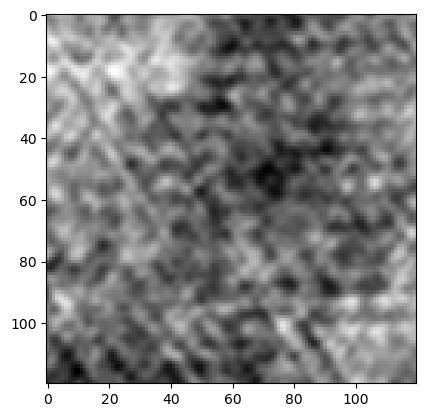

In [58]:
plt.imshow(resized_test_img_slice[0])
plt.show()

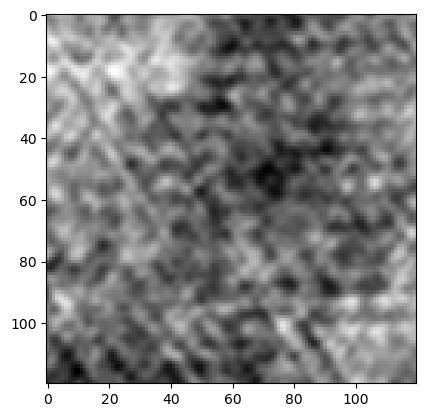

In [59]:
plt.imshow(normalise_img(test_img_slice[0]))
plt.show()

In [60]:
# Check for nan values in the test data.
sum(sum(sum(np.isnan(test_img_slice))))

array([0, 0, 0])

In [61]:
# Check the value counts in the test image labels.
test_img_labels.value_counts()

Above_Threshold
2    484
1    482
0    479
Name: count, dtype: int64

#### Get Training Image Slices and Labels

In [62]:
train_img_labels, train_img_slice = get_img_slices_and_labels(train_df)

In [63]:
resized_train_img_slice = resize_img_slice(train_img_slice, new_size = desired_size)

Check if the resized images match the original images or normalised images.

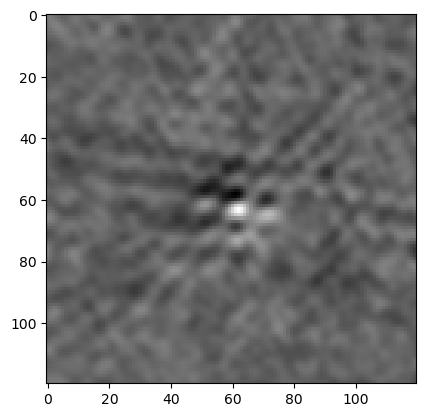

In [64]:
plt.imshow(resized_train_img_slice[0])
plt.show()

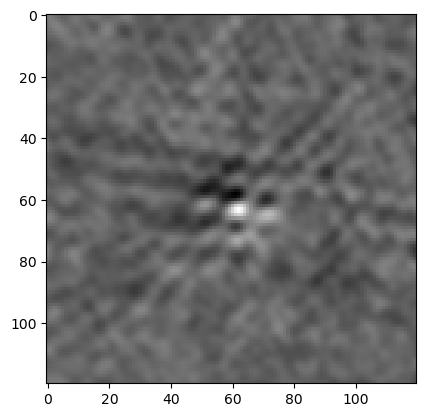

In [65]:
plt.imshow(normalise_img(train_img_slice[0]))
plt.show()

In [66]:
train_img_slice.shape

(2367, 120, 120, 3)

In [67]:
train_img_labels.value_counts()

Above_Threshold
2    794
1    794
0    779
Name: count, dtype: int64

#### Get Validation Image Slices and Labels

In [68]:
val_img_labels, val_img_slice = get_img_slices_and_labels(val_df)

In [69]:
resized_val_img_slice = resize_img_slice(val_img_slice, new_size = desired_size)

Check if the resized images match the original images or normalised images.

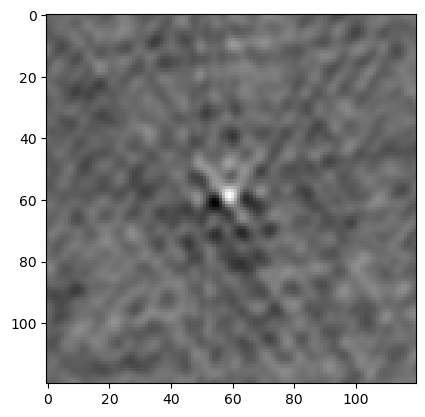

In [70]:
plt.imshow(resized_val_img_slice[0])
plt.show()

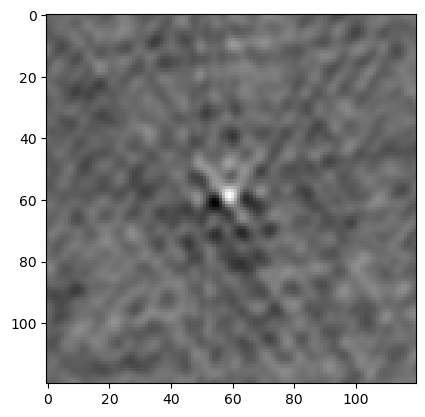

In [71]:
plt.imshow(normalise_img(val_img_slice[0]))
plt.show()

In [72]:
val_img_slice.shape

(1008, 120, 120, 3)

In [73]:
val_img_labels.value_counts()

Above_Threshold
2    337
0    336
1    335
Name: count, dtype: int64

#### Save The Image Slices and Their Labels

In [74]:
def save_img_slice(img_slice_data, img_labels_data, data_class, data_fol = "CNN_Data"):
    """
    Save the images.

    Parameters
    ----------
    img_slice_data : numpy array
        The images

    img_labels : pandas series
        The labels for the images

    data_class : str
        Whether the image belongs to "Train", "Validation" or "Test" folders

    data_fol : str, default "CNN_Data"
        The folder the images will be saved in
    """
    
    f_path = f"{data_fol}/{data_class}/{data_class}"
    np.save(f_path+"_Imgs", img_slice_data)
    np.save(f_path+"_Labels", img_labels_data)

In [75]:
save_img_slice(resized_test_img_slice, test_img_labels, "Test", data_fol = "CNN_Data")
save_img_slice(resized_train_img_slice, train_img_labels, "Train", data_fol = "CNN_Data")
save_img_slice(resized_val_img_slice, val_img_labels, "Validation", data_fol = "CNN_Data")